# General Set up

### Imports

In [ ]:
# loading data
import os
import zipfile
import glob


# transforming data
import torchvision.transforms as transforms
from typing import Tuple, Sequence
from torch.utils.data import Dataset
from PIL import Image


# General
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import cv2

# resnet
from torchvision.models import resnet50

# densenet
from torchvision.models import densenet121

# VGG Face
from torchvision.models import vgg16

# inceptionV3
from torchvision.models import inception_v3

# train
import torch.optim as optim

# test

# analyze
from torchvision import datasets
from torch.utils.data import DataLoader


### Load Colored Data

You will need to follow the instructions here on how to get your kaggle api key: https://christianjmills.com/posts/kaggle-obtain-api-key-tutorial/

Dataset: https://www.kaggle.com/datasets/fatihkgg/affectnet-yolo-format

In [ ]:
!pip install kaggle
from google.colab import files

# Upload your Kaggle API key JSON file
# Go to kaggle.com account and generate new api key json
files.upload()

# Make sure the dataset path is correct
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset
!kaggle datasets download -d fatihkgg/affectnet-yolo-format

# Unzip zip file
!unzip -o affectnet-yolo-format.zip -d /content/colored_facial_data

### Create a duplicate Black & White dataset

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image

# Define the path to the zip file and the extraction directory
zip_path = '/content/affectnet-yolo-format.zip'  # Change this to your actual zip file path
extract_dir = '/content/bw_facial_data'   # Change this to your desired extraction folder

# Create the directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Dataset extracted to {extract_dir}")

for root, dirs, files in os.walk(extract_dir):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            img_path = os.path.join(root, file)

            # Read and convert to grayscale
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            # Overwrite the original with the grayscale version
            cv2.imwrite(img_path, img)

print("All images converted to black and white.")

Dataset extracted to /content/bw_facial_data
All images converted to black and white.


In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image

# Load image from file path
colored_image_path = '/content/colored_facial_data/YOLO_format/train/images/ffhq_0.png'  # replace with your image path
colored_image = Image.open(colored_image_path)

bw_image_path = '/content/bw_facial_data/YOLO_format/train/images/ffhq_0.png'  # replace with your image path
bw_image = Image.open(bw_image_path)


# Display image using matplotlib
plt.imshow(colored_image)
plt.axis('off')  # hide axes
plt.title("Colored Image")
plt.show()

# Display image using matplotlib
plt.imshow(bw_image, cmap='gray')
plt.axis('off')  # hide axes
plt.title("bw Image")
plt.show()

##### Restructuring folders

In [ ]:
import os
import shutil

def restructure_yolo_dataset_by_class(images_dir, labels_dir, output_dir, labels_map):
    """
    Restructure a YOLO-format dataset so that images are grouped into subfolders
    based on the class label found in their corresponding .txt label files.

    Parameters:
        images_dir (str): Path to the folder containing image files.
        labels_dir (str): Path to the folder containing YOLO-format .txt labels.
        output_dir (str): Path to the output folder where images will be organized by class.
        labels_map (dict): Mapping from YOLO class ID (as str) to class name.
    """

    # Create output subdirectories
    for class_name in labels_map.values():
        class_folder = os.path.join(output_dir, class_name)
        os.makedirs(class_folder, exist_ok=True)

    # Iterate through label files
    for label_file in os.listdir(labels_dir):
        if not label_file.endswith('.txt'):
            continue

        label_path = os.path.join(labels_dir, label_file)

        with open(label_path, 'r') as f:
            first_line = f.readline().strip()
            if not first_line:
                continue  # skip empty label files
            class_id = first_line.split()[0]

        # Convert class ID to class name
        class_name = labels_map.get(class_id)
        if class_name is None:
            continue  # skip unknown classes

        # Look for the image with matching base name
        base_name = os.path.splitext(label_file)[0]
        for ext in ['.jpg', '.png', '.jpeg', '.bmp']:
            image_path = os.path.join(images_dir, base_name + ext)
            if os.path.exists(image_path):
                dest_path = os.path.join(output_dir, class_name, base_name + ext)
                shutil.copy(image_path, dest_path)
                break  # only copy the first image that matches

    print(f"✅ Restructured dataset saved to: {output_dir}")

In [ ]:
import os
import shutil

# Class labels map
labels_map = {
    '0': 'Anger',
    '1': 'Contempt',
    '2': 'Disgust',
    '3': 'Fear',
    '4': 'Happy',
    '5': 'Neutral',
    '6': 'Sad',
    '7': 'Surprise'
}

# colored data

# Define paths
colored_train_images_dir = "/content/colored_facial_data/YOLO_format/train/images"
colored_train_labels_dir = "/content/colored_facial_data/YOLO_format/train/labels"
colored_train_output_dir = "/content/reorged_colored_facial_data/train/images"

restructure_yolo_dataset_by_class(colored_train_images_dir, colored_train_labels_dir, colored_train_output_dir, labels_map)

# Define paths
colored_valid_images_dir = "/content/colored_facial_data/YOLO_format/valid/images"
colored_valid_labels_dir = "/content/colored_facial_data/YOLO_format/valid/labels"
colored_valid_output_dir = "/content/reorged_colored_facial_data/valid/images"

restructure_yolo_dataset_by_class(colored_valid_images_dir, colored_valid_labels_dir, colored_valid_output_dir, labels_map)

# Define paths
colored_test_images_dir = "/content/colored_facial_data/YOLO_format/test/images"
colored_test_labels_dir = "/content/colored_facial_data/YOLO_format/test/labels"
colored_test_output_dir = "/content/reorged_colored_facial_data/test/images"

restructure_yolo_dataset_by_class(colored_test_images_dir, colored_test_labels_dir, colored_test_output_dir, labels_map)

# black and white data

# Define paths
bw_train_images_dir = "/content/bw_facial_data/YOLO_format/train/images"
bw_train_labels_dir = "/content/bw_facial_data/YOLO_format/train/labels"
bw_train_output_dir = "/content/reorged_bw_facial_data/train/images"

restructure_yolo_dataset_by_class(bw_train_images_dir, bw_train_labels_dir, bw_train_output_dir, labels_map)

# Define paths
bw_valid_images_dir = "/content/bw_facial_data/YOLO_format/valid/images"
bw_valid_labels_dir = "/content/bw_facial_data/YOLO_format/valid/labels"
bw_valid_output_dir = "/content/reorged_bw_facial_data/valid/images"

restructure_yolo_dataset_by_class(bw_valid_images_dir, bw_valid_labels_dir, bw_valid_output_dir, labels_map)

# Define paths
bw_test_images_dir = "/content/bw_facial_data/YOLO_format/test/images"
bw_test_labels_dir = "/content/bw_facial_data/YOLO_format/test/labels"
bw_test_output_dir = "/content/reorged_bw_facial_data/test/images"

restructure_yolo_dataset_by_class(bw_test_images_dir, bw_test_labels_dir, bw_test_output_dir, labels_map)


In [ ]:
import os

def display_image_counts_by_class(output_dir):

    # Iterate through subdirectories (which represent classes)
    for class_name in os.listdir(output_dir):
        class_folder = os.path.join(output_dir, class_name)

        if os.path.isdir(class_folder):
            # Count image files (e.g., jpg, png, jpeg, bmp)
            image_count = 0
            for ext in ['.jpg', '.png', '.jpeg', '.bmp']:
                image_count += len([f for f in os.listdir(class_folder) if f.endswith(ext)])

            # Display the count for this class
            print(f"Class: {class_name} - Images: {image_count}")

# Example usage:
output_dir = '/content/reorged_colored_facial_data/train/images'
display_image_counts_by_class(output_dir)

In [ ]:
import os
import random

def quarter_image_dataset(output_dir):
    # Iterate through class folders
    for class_name in os.listdir(output_dir):
        class_folder = os.path.join(output_dir, class_name)

        if os.path.isdir(class_folder):
            # Get all image files
            image_files = [f for f in os.listdir(class_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

            # Determine number to keep (25%)
            num_to_keep = max(1, len(image_files) // 4)  # Ensure at least one image remains

            # Randomly select images to keep
            images_to_keep = set(random.sample(image_files, num_to_keep))

            # Remove the rest
            for f in image_files:
                if f not in images_to_keep:
                    os.remove(os.path.join(class_folder, f))

            print(f"Class: {class_name} - Kept {num_to_keep} of {len(image_files)} images")

output_dir = '/content/reorged_colored_facial_data/train/images'
quarter_image_dataset(output_dir)

output_dir = '/content/reorged_colored_facial_data/test/images'
quarter_image_dataset(output_dir)

output_dir = '/content/reorged_colored_facial_data/valid/images'
quarter_image_dataset(output_dir)

# Prep Data

##### Transform Data

In [ ]:
def get_transforms_colored_train(inp_size, pixel_mean, pixel_std):
    # No change needed for colored images
    return transforms.Compose([
        transforms.RandomResizedCrop(inp_size, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(0.6),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
        transforms.ToTensor(),
        transforms.Normalize(mean=pixel_mean, std=pixel_std)  # For 3-channel images (RGB)
    ])

def get_transforms_bw_train(inp_size, pixel_mean, pixel_std):
    # Adjust normalization for grayscale images (1 channel)
    return transforms.Compose([
        transforms.Resize(inp_size),
        transforms.RandomHorizontalFlip(0.6),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[pixel_mean], std=[pixel_std])  # Use single value for mean and std for grayscale
    ])

def get_transforms_colored_val(inp_size, pixel_mean, pixel_std):
    return transforms.Compose([
        transforms.Resize(inp_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=pixel_mean, std=pixel_std)  # For 3-channel images (RGB)
    ])

def get_transforms_bw_val(inp_size, pixel_mean, pixel_std):
    return transforms.Compose([
        transforms.Resize(inp_size),
        transforms.ToTensor(),
        transforms.Grayscale(num_output_channels=1),
        transforms.Normalize(mean=[pixel_mean], std=[pixel_std])  # Use single value for mean and std for grayscale
    ])


In [ ]:
# Define input size and normalization parameters
image_size = (299, 299)
pixel_mean = [0.485, 0.456, 0.406]
pixel_std = [0.229, 0.224, 0.225]

pixel_mean_bw = [0.5]
pixel_std_bw = [0.5]

In [ ]:
# Apply transformations
transform_colored_train = get_transforms_colored_train(image_size, pixel_mean, pixel_std)
transform_bw_train = get_transforms_bw_train(image_size, pixel_mean_bw, pixel_std_bw)

transform_colored_val = get_transforms_colored_val(image_size, pixel_mean, pixel_std)
transform_bw_val = get_transforms_bw_val(image_size, pixel_mean_bw, pixel_std_bw)

transform_colored_test = get_transforms_colored_val(image_size, pixel_mean, pixel_std)
transform_bw_test = get_transforms_bw_val(image_size, pixel_mean_bw, pixel_std_bw)

##### Create Custom Dataset

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [ ]:
colored_data_dir = "/content/reorged_colored_facial_data"
bw_data_dir = "/content/reorged_bw_facial_data"

In [ ]:
colored_train_images = f"{colored_data_dir}/train/images"
colored_val_images = f"{colored_data_dir}/valid/images"
colored_test_images = f"{colored_data_dir}/test/images"

bw_train_images = f"{bw_data_dir}/train/images"
bw_val_images = f"{bw_data_dir}/valid/images"
bw_test_images = f"{bw_data_dir}/test/images"


In [ ]:
colored_train_dataset = datasets.ImageFolder(root=colored_train_images, transform=transform_colored_train)
colored_valid_dataset = datasets.ImageFolder(root=colored_val_images, transform=transform_colored_val)

print("colored datasets initialized")

bw_train_dataset = datasets.ImageFolder(root=colored_train_images, transform=transform_bw_train)
bw_valid_dataset = datasets.ImageFolder(root=colored_val_images, transform=transform_bw_val)

print("bw datasets initialized")

In [ ]:
colored_train_loader = DataLoader(colored_train_dataset, batch_size=64, shuffle=True)
colored_valid_loader = DataLoader(colored_valid_dataset, batch_size=64, shuffle=False)
colored_test_loader = DataLoader(colored_valid_dataset, batch_size=64, shuffle=False)


bw_train_loader = DataLoader(bw_train_dataset, batch_size=64, shuffle=True)
bw_valid_loader = DataLoader(bw_valid_dataset, batch_size=64, shuffle=False)
bw_test_loader = DataLoader(bw_valid_dataset, batch_size=64, shuffle=False)

In [ ]:
# print(colored_train_dataset)

# Train

In [ ]:
# progress visualization
from tqdm import tqdm

def train_model(model, train_loader, val_loader, epochs=10, lr=0.001, optimizer=None, loss_fn=None, bw=False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Loss function: CrossEntropy without class weights or label smoothing
    criterion = loss_fn if loss_fn is not None else torch.nn.CrossEntropyLoss()

    # Use provided optimizer or create one
    if optimizer is None:
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

    best_val_acc = 0.0
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]", leave=False)

        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)

            if isinstance(outputs, tuple):  # Check if aux_logits=True
                outputs = outputs[0]

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            loop.set_postfix(loss=running_loss/len(train_loader), acc=100. * correct / total)

            torch.cuda.empty_cache()

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        val_acc = 100. * val_correct / val_total
        avg_val_loss = val_loss / len(val_loader)

        train_losses.append(running_loss / len(train_loader))
        val_losses.append(avg_val_loss)

        print(f"📊 Epoch {epoch+1}: Train Loss = {running_loss/len(train_loader):.4f}, "
              f"Val Loss = {avg_val_loss:.4f}, Val Acc = {val_acc:.2f}%")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            if bw:
                torch.save(model.state_dict(), f"{model.__class__.__name__}_bw_best_model.pth")
            else:
                torch.save(model.state_dict(), f"{model.__class__.__name__}_color_best_model.pth")

            print(f"✅ Best model saved with Val Acc = {val_acc:.2f}%")

    print("🎉 Training complete.")
    return train_losses, val_losses

In [ ]:
def call_model_train(model, train_color_loader, val_color_loader, train_bw_loader, val_bw_loader, epochs=100, lr=0.001, loss_fn=None):

  print("\nTraining on Colored Data:")
  train_model(model, train_color_loader, val_color_loader,epochs=epochs, lr=lr, bw=False, loss_fn=loss_fn)

  print("\nTraining on Black & White Data:")
  train_model(model, train_bw_loader, val_bw_loader, epochs=epochs, lr=lr, bw=True, loss_fn=loss_fn)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def confusion_matrix_eval(model, is_bw):

  device = torch.device("cuda" if torch.cuda.is_available() else "gpu")

  y_true = []
  y_pred = []
  model.eval()

  with torch.no_grad():
      if is_bw:
        loader = bw_valid_loader
        print("Black white loader:")
      else:
        print("Colored loader:")
        loader = colored_valid_loader

      for images, labels in loader:
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs, 1)
          y_true.extend(labels.cpu().numpy())
          y_pred.extend(predicted.cpu().numpy())

  cm = confusion_matrix(y_true, y_pred)
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(8), yticklabels=range(8))
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.show()

# Test

In [ ]:
from sklearn.metrics import accuracy_score

def test_model(model, test_loader, loss_fn=None):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()  # set model to eval mode

    criterion = loss_fn if loss_fn is not None else torch.nn.CrossEntropyLoss()

    all_preds = []
    all_labels = []
    total_loss = 0.0

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing"):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Predictions
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute metrics
    avg_loss = total_loss / len(test_loader)
    accuracy = accuracy_score(all_labels, all_preds)

    print(f"\nTest Loss: {avg_loss:.4f} | Test Accuracy: {accuracy * 100:.2f}%")
    return avg_loss, accuracy, all_preds, all_labels

In [ ]:
import matplotlib.pyplot as plt

def plot_loss_curves(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    plt.title('Training & Validation Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Models

### ResNet

https://cs230.stanford.edu/files_winter_2018/projects/6931955.pdf

##### Pre-Trained

In [ ]:
import torch
import torch.nn as nn
from torchvision import models
from torchvision.models import ResNet18_Weights, ResNet50_Weights

def get_emotion_resnet(model_name='resnet18', num_classes=8, pretrained=True, bw=False, use_dropout=False):
    # Load the base model
    weight_map = {
        'resnet18': ResNet18_Weights.DEFAULT,
        'resnet50': ResNet50_Weights.DEFAULT,
    }

    # Load the base model with or without pretrained weights
    weights = weight_map[model_name] if pretrained else None
    resnet = getattr(models, model_name)(weights=weights)

    # Get the number of features in the final FC layer
    in_features = resnet.fc.in_features

    # conditional usage of dropout layer
    if use_dropout:
        resnet.fc = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features, num_classes)
        )
    else:
        resnet.fc = nn.Linear(in_features, num_classes)

    # Adjust input layer for grayscale images if needed
    if bw:
        resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

    return resnet

In [ ]:
import random
from torch.utils.data import Subset
from tqdm import tqdm
import torch.optim as optim
import torch


def train_resnet_model(model, train_loader, val_loader, epochs=10, lr=0.001, optimizer=None, loss_fn=None, bw=False, train_fraction=1.0):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = loss_fn if loss_fn is not None else torch.nn.CrossEntropyLoss()
    if optimizer is None:
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    best_val_acc = 0.0
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        """
        # Get a random subset of the training data
        train_data_list = list(train_loader)
        random.shuffle(train_data_list)
        subset_size = int(len(train_data_list) * train_fraction)
        train_subset = train_data_list[:subset_size]
        """

        # Create a new Subset for the fraction
        num_samples = int(len(train_loader.dataset) * train_fraction)
        indices = random.sample(range(len(train_loader.dataset)), num_samples)
        subset_dataset = Subset(train_loader.dataset, indices)

        # Create a temporary DataLoader
        subset_loader = DataLoader(subset_dataset, batch_size=train_loader.batch_size, shuffle=True, num_workers=0)

        #loop = tqdm(train_subset, desc=f"Epoch {epoch+1}/{epochs} [Train]", leave=False)
        loop = tqdm(subset_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]", leave=False)


        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            if isinstance(outputs, tuple):
                outputs = outputs[0]

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            loop.set_postfix(loss=running_loss/len(subset_loader), acc=100. * correct / total)

        # Validation remains unchanged
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        val_acc = 100. * val_correct / val_total
        avg_val_loss = val_loss / len(val_loader)

        train_losses.append(running_loss / len(subset_loader))
        val_losses.append(avg_val_loss)

        print(f"📊 Epoch {epoch+1}: Train Loss = {running_loss/len(subset_loader):.4f}, "
              f"Val Loss = {avg_val_loss:.4f}, Val Acc = {val_acc:.2f}%")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            save_name = f"{model.__class__.__name__}_{'bw' if bw else 'color'}_best_model.pth"
            torch.save(model.state_dict(), save_name)
            print(f"✅ Best model saved with Val Acc = {val_acc:.2f}%")

    print("🎉 Training complete.")
    return train_losses, val_losses

In [ ]:
print("\nTraining on Colored Data:")
model = get_emotion_resnet('resnet18', num_classes=8, pretrained=True, bw=False)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
colored_train_losses, colored_val_losses = train_resnet_model(model, colored_train_loader, colored_valid_loader,epochs=20, lr=0.1, optimizer=optimizer, bw=False, loss_fn=None, train_fraction=0.75)

confusion_matrix_eval(model, False)

model.load_state_dict(torch.load("ResNet_color_best_model.pth", map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu")))
test_loss, test_acc, y_pred, y_true = test_model(model, colored_test_loader)

print("colored loss:")
plot_loss_curves(colored_train_losses, colored_val_losses)

print("\nTraining on Black & White Data:")
model = get_emotion_resnet('resnet18', num_classes=8, pretrained=True, bw=True)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
bw_train_losses, bw_val_losses = train_resnet_model(model, bw_train_loader, bw_valid_loader, epochs=20, lr=0.1, optimizer=optimizer, bw=True, loss_fn=None, train_fraction=0.75)

confusion_matrix_eval(model, True)

model.load_state_dict(torch.load("ResNet_bw_best_model.pth", map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu")))
test_loss, test_acc, y_pred, y_true = test_model(model, bw_test_loader)

print("bw loss:")
plot_loss_curves(bw_train_losses, bw_val_losses)

### DenseNet

https://cs230.stanford.edu/files_winter_2018/projects/6931955.pdf

##### Pretrained

In [ ]:
import torch
import torch.nn as nn
from torchvision import models
from torchvision.models import DenseNet121_Weights

def get_emotion_densenet(model_name='densenet121', num_classes=7, pretrained=True, bw=False):
    # Map model name to corresponding weights
    weight_map = {
        'densenet121': DenseNet121_Weights.DEFAULT,
    }

    # Load pretrained weights if requested
    weights = weight_map[model_name] if pretrained else None
    densenet = getattr(models, model_name)(weights=weights)

    if bw:
        old_conv = densenet.features.conv0
        new_conv = nn.Conv2d(
            in_channels=1,
            out_channels=old_conv.out_channels,
            kernel_size=old_conv.kernel_size,
            stride=old_conv.stride,
            padding=old_conv.padding,
            bias=False
        )
        # Copy weights by averaging across channels
        with torch.no_grad():
            new_conv.weight[:] = old_conv.weight.mean(dim=1, keepdim=True)
        densenet.features.conv0 = new_conv

    # Replace the classifier
    in_features = densenet.classifier.in_features
    densenet.classifier = nn.Sequential(
        nn.Dropout(p=0.4),
        nn.Linear(in_features, num_classes)
    )

    return densenet


Training on Colored Data:


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 148MB/s]


📊 Epoch 1: Train Loss = 1.4335, Val Loss = 1.0940, Val Acc = 58.92%
✅ Best model saved with Val Acc = 58.92%


📊 Epoch 2: Train Loss = 0.9999, Val Loss = 1.3108, Val Acc = 58.75%


📊 Epoch 3: Train Loss = 0.8805, Val Loss = 0.8514, Val Acc = 68.13%
✅ Best model saved with Val Acc = 68.13%


📊 Epoch 4: Train Loss = 0.8104, Val Loss = 0.8980, Val Acc = 67.11%


📊 Epoch 5: Train Loss = 0.7391, Val Loss = 0.9671, Val Acc = 66.63%
🎉 Training complete.
Colored loader:


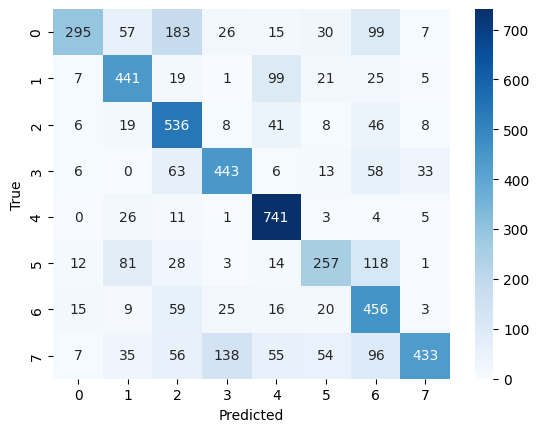

Testing: 100%|██████████| 85/85 [00:47<00:00,  1.81it/s]



Test Loss: 0.8514 | Test Accuracy: 68.13%

Training on Black & White Data:


📊 Epoch 1: Train Loss = 2.1581, Val Loss = 2.0987, Val Acc = 14.35%
✅ Best model saved with Val Acc = 14.35%


📊 Epoch 2: Train Loss = 2.1622, Val Loss = 2.0981, Val Acc = 14.37%
✅ Best model saved with Val Acc = 14.37%


📊 Epoch 3: Train Loss = 2.1620, Val Loss = 2.0969, Val Acc = 14.52%
✅ Best model saved with Val Acc = 14.52%


📊 Epoch 4: Train Loss = 2.1658, Val Loss = 2.1001, Val Acc = 14.17%


📊 Epoch 5: Train Loss = 2.1588, Val Loss = 2.0978, Val Acc = 14.63%
✅ Best model saved with Val Acc = 14.63%
🎉 Training complete.
Black white loader:


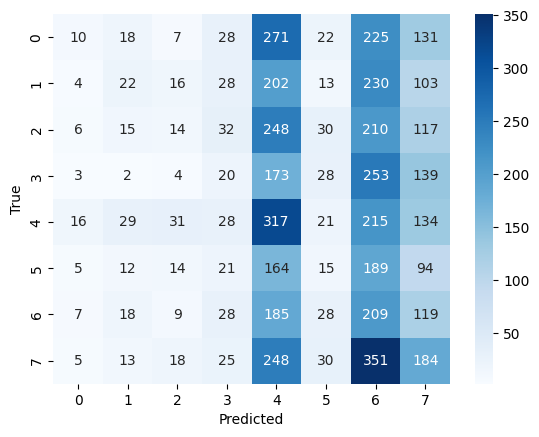

Testing: 100%|██████████| 85/85 [00:43<00:00,  1.98it/s]


Test Loss: 2.0978 | Test Accuracy: 14.63%
colored loss:


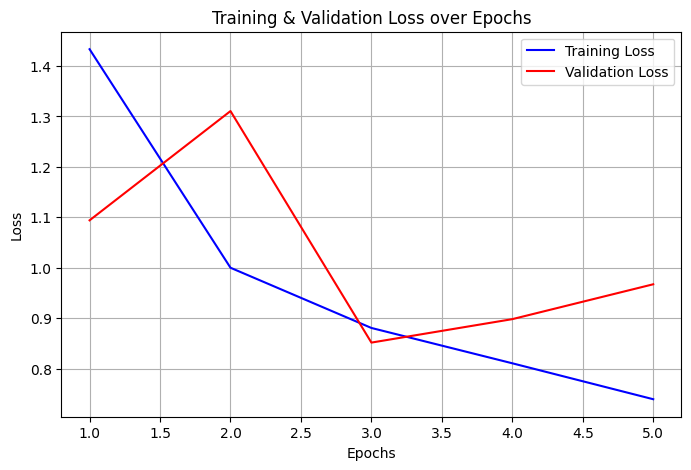

bw loss:


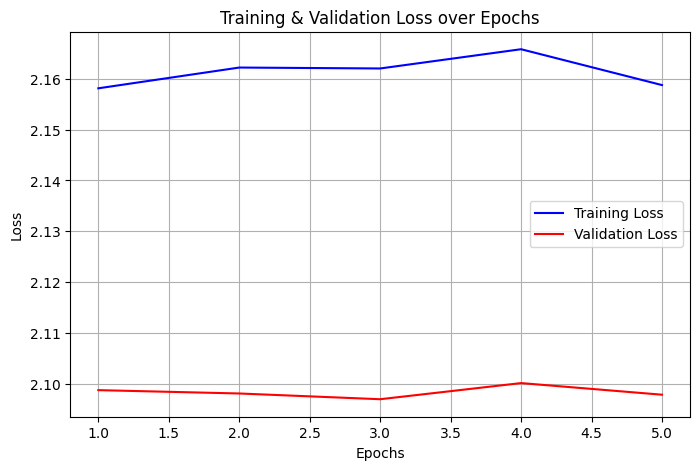

In [ ]:
print("\nTraining on Colored Data:")
model = get_emotion_densenet(model_name='densenet121', num_classes=8, pretrained=True, bw=False)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
colored_train_losses, colored_val_losses = train_model(model, colored_train_loader, colored_valid_loader,epochs=5, lr=1e-5, optimizer=optimizer, bw=False, loss_fn=None)

confusion_matrix_eval(model, False)

model.load_state_dict(torch.load("DenseNet_color_best_model.pth", map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu")))
test_loss, test_acc, y_pred, y_true = test_model(model, colored_test_loader)

print("\nTraining on Black & White Data:")
model = get_emotion_densenet(model_name='densenet121', num_classes=8, pretrained=True, bw=True)
bw_train_losses, bw_val_losses = train_model(model, bw_train_loader, bw_valid_loader, epochs=5, lr=1e-5, optimizer=optimizer, bw=True, loss_fn=None)

confusion_matrix_eval(model, True)

model.load_state_dict(torch.load("DenseNet_bw_best_model.pth", map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu")))
test_loss, test_acc, y_pred, y_true = test_model(model, bw_test_loader)

print("colored loss:")
plot_loss_curves(colored_train_losses, colored_val_losses)

print("bw loss:")
plot_loss_curves(bw_train_losses, bw_val_losses)

### VGG-Face

https://ieeexplore.ieee.org/document/10133972

##### Pretrained:

In [ ]:
import torch
import torch.nn as nn
from torchvision import models
from torchvision.models import VGG16_Weights

def get_emotion_vgg16(model_name='vgg16', num_classes=7, pretrained=True, bw=False):
    # Map model name to corresponding weights
    weight_map = {
        'vgg16': VGG16_Weights.DEFAULT,
    }

    # Load pretrained weights if requested
    weights = weight_map[model_name] if pretrained else None
    vgg = getattr(models, model_name)(weights=weights)

    if bw:
        # Modify the first conv layer to accept 1-channel input (grayscale)
        old_conv = vgg.features[0]
        new_conv = nn.Conv2d(
            in_channels=1,
            out_channels=old_conv.out_channels,
            kernel_size=old_conv.kernel_size,
            stride=old_conv.stride,
            padding=old_conv.padding,
            bias=False
        )
        # Copy weights by averaging across the RGB channels
        if pretrained:
            with torch.no_grad():
                new_conv.weight[:] = old_conv.weight.mean(dim=1, keepdim=True)
        vgg.features[0] = new_conv

    # Replace the classifier
    in_features = vgg.classifier[6].in_features
    vgg.classifier[6] = nn.Sequential(
        nn.Dropout(p=0.4),
        nn.Linear(in_features, num_classes)
    )

    return vgg


Training on Colored Data:


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 125MB/s]


📊 Epoch 1: Train Loss = 1.6733, Val Loss = 1.5105, Val Acc = 42.86%
✅ Best model saved with Val Acc = 42.86%


📊 Epoch 2: Train Loss = 1.2843, Val Loss = 1.1276, Val Acc = 57.58%
✅ Best model saved with Val Acc = 57.58%


📊 Epoch 3: Train Loss = 1.0819, Val Loss = 1.0412, Val Acc = 61.58%
✅ Best model saved with Val Acc = 61.58%


📊 Epoch 4: Train Loss = 1.0055, Val Loss = 0.9173, Val Acc = 66.26%
✅ Best model saved with Val Acc = 66.26%


📊 Epoch 5: Train Loss = 0.8937, Val Loss = 0.9662, Val Acc = 64.02%
🎉 Training complete.
Colored loader:


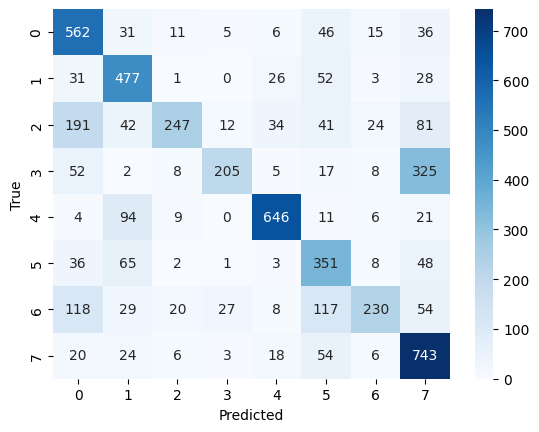

Testing: 100%|██████████| 85/85 [01:06<00:00,  1.28it/s]



Test Loss: 0.9173 | Test Accuracy: 66.26%

Training on Black & White Data:


📊 Epoch 1: Train Loss = 1.7924, Val Loss = 1.5210, Val Acc = 40.38%
✅ Best model saved with Val Acc = 40.38%


📊 Epoch 2: Train Loss = 1.2932, Val Loss = 1.1762, Val Acc = 55.23%
✅ Best model saved with Val Acc = 55.23%


📊 Epoch 3: Train Loss = 1.0809, Val Loss = 1.0310, Val Acc = 60.91%
✅ Best model saved with Val Acc = 60.91%


📊 Epoch 4: Train Loss = 0.9478, Val Loss = 0.9720, Val Acc = 63.26%
✅ Best model saved with Val Acc = 63.26%


📊 Epoch 5: Train Loss = 0.8478, Val Loss = 0.9584, Val Acc = 65.26%
✅ Best model saved with Val Acc = 65.26%
🎉 Training complete.
Black white loader:


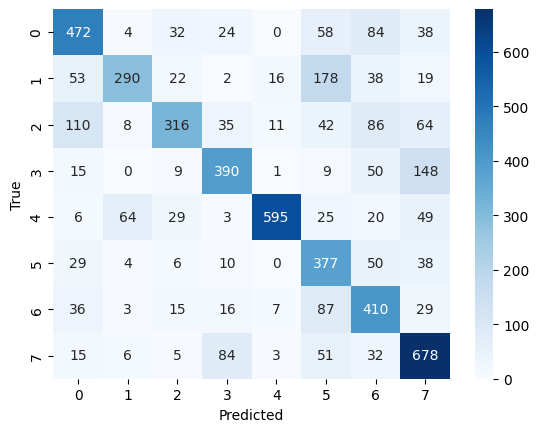

Testing: 100%|██████████| 85/85 [01:00<00:00,  1.40it/s]


Test Loss: 0.9584 | Test Accuracy: 65.26%
colored loss:


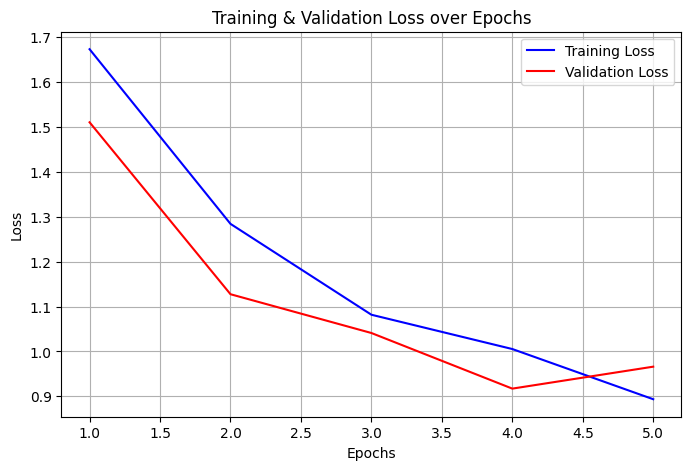

bw loss:


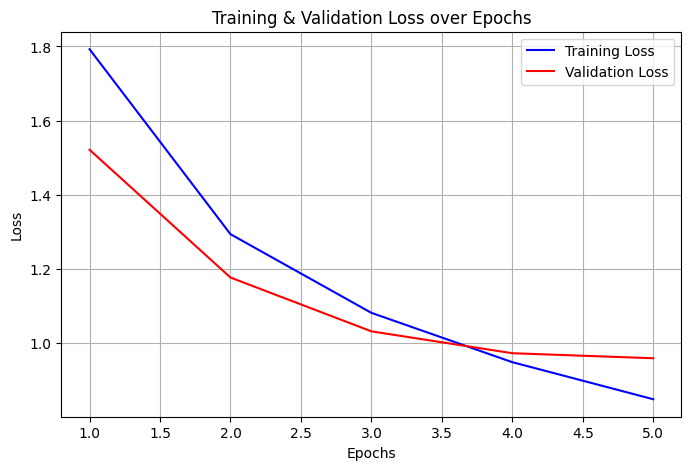

In [ ]:
print("\nTraining on Colored Data:")
model = get_emotion_vgg16(model_name='vgg16', num_classes=8, pretrained=True, bw=False)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
colored_train_losses, colored_val_losses = train_model(model, colored_train_loader, colored_valid_loader,epochs=5, lr=1e-5, optimizer=optimizer, bw=False, loss_fn=None)

confusion_matrix_eval(model, False)

model.load_state_dict(torch.load("VGG_color_best_model.pth", map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu")))
test_loss, test_acc, y_pred, y_true = test_model(model, colored_test_loader)

print("\nTraining on Black & White Data:")
model = get_emotion_vgg16(model_name='vgg16', num_classes=8, pretrained=True, bw=True)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
bw_train_losses, bw_val_losses = train_model(model, bw_train_loader, bw_valid_loader, epochs=5, lr=1e-5, optimizer=optimizer, bw=True, loss_fn=None)

confusion_matrix_eval(model, True)

model.load_state_dict(torch.load("VGG_bw_best_model.pth", map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu")))
test_loss, test_acc, y_pred, y_true = test_model(model, bw_test_loader)

print("colored loss:")
plot_loss_curves(colored_train_losses, colored_val_losses)

print("bw loss:")
plot_loss_curves(bw_train_losses, bw_val_losses)

### EfficientNet

In [ ]:
import torch
import torch.nn as nn
from torchvision import models
from torchvision.models import EfficientNet_B0_Weights

def get_emotion_effnetb0(model_name='efficientnet_b0',num_classes=8, pretrained=True, bw=False):
    # Select appropriate weights
    weights = EfficientNet_B0_Weights.DEFAULT if pretrained else None

    # Load the EfficientNetB0 model with or without weights
    effnet = models.efficientnet_b0(weights=weights)

    if bw:
        # Modify the first conv layer to accept 1-channel (grayscale) input
        old_conv = effnet.features[0][0]
        new_conv = nn.Conv2d(
            in_channels=1,
            out_channels=old_conv.out_channels,
            kernel_size=old_conv.kernel_size,
            stride=old_conv.stride,
            padding=old_conv.padding,
            bias=old_conv.bias is not None
        )
        if weights is not None:
            with torch.no_grad():
                new_conv.weight[:] = old_conv.weight.mean(dim=1, keepdim=True)
        effnet.features[0][0] = new_conv

    # Replace the classifier head
    in_features = effnet.classifier[1].in_features
    effnet.classifier = nn.Sequential(
        nn.Dropout(p=0.4, inplace=True),
        nn.Linear(in_features, num_classes)
    )

    return effnet

In [ ]:

print("\nTraining on Colored Data:")
model = get_emotion_effnetb0(model_name='efficientnet_b0', num_classes=8, pretrained=True, bw=False)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0003, weight_decay=1e-4)
colored_train_losses, colored_val_losses = train_model(model, colored_train_loader, colored_valid_loader,epochs=5, lr=1e-5, optimizer=optimizer, bw=False, loss_fn=None)

confusion_matrix_eval(model, False)

model.load_state_dict(torch.load("EfficientNet_color_best_model.pth", map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu")))
test_loss, test_acc, y_pred, y_true = test_model(model, colored_test_loader)

print("\nTraining on Black & White Data:")
model = get_emotion_effnetb0(model_name='efficientnet_b0', num_classes=8, pretrained=True, bw=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0003, weight_decay=1e-4)
bw_train_losses, bw_val_losses = train_model(model, bw_train_loader, bw_valid_loader, epochs=5, lr=1e-5, optimizer=optimizer, bw=True, loss_fn=None,)

confusion_matrix_eval(model, True)

model.load_state_dict(torch.load("EfficientNet_bw_best_model.pth", map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu")))
test_loss, test_acc, y_pred, y_true = test_model(model, bw_test_loader)

print("colored loss:")
plot_loss_curves(colored_train_losses, colored_val_losses)

print("bw loss:")
plot_loss_curves(bw_train_losses, bw_val_losses)


Training on Colored Data:


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 111MB/s] 
Epoch 1/5 [Train]:   3%|▎         | 2/67 [01:32<49:38, 45.83s/it, acc=17.2, loss=0.0622]

# Compare

##### Train & Test all models

In [ ]:
def train_all_models():
    models_to_train = [
        ResNet50(),
        MyDenseNet(),
        VGGFaceEmotionModel(num_classes=8),
        MyInceptionV3(num_classes=8)
    ]

    for model in models_to_train:
        print(f"Training model: {model.__class__.__name__}")


        call_model_train(model, colored_train_loader, colored_val_loader, bw_train_loader, bw_val_loader, epochs=10, lr=1e-3)

        # Test the model on colored data
        print("\nTesting on Colored Data:")
        test_model(model, colored_test_loader)

        # Test the model on black-and-white data
        print("\nTesting on Black & White Data:")
        test_model(model, bw_test_loader)

        confusion_matrix_eval(model, True)
        confusion_matrix_eval(model, False)

Training model: ResNet50

Training on Colored Data:


📊 Epoch 1: Train Loss = 2.8810, Val Loss = 2.5492, Val Acc = 5.70%
✅ Best model saved with Val Acc = 5.70%


📊 Epoch 2: Train Loss = 2.1962, Val Loss = 12.9635, Val Acc = 22.81%
✅ Best model saved with Val Acc = 22.81%


📊 Epoch 3: Train Loss = 2.2204, Val Loss = 2.8308, Val Acc = 26.75%
✅ Best model saved with Val Acc = 26.75%


📊 Epoch 4: Train Loss = 2.2557, Val Loss = 3.3565, Val Acc = 17.11%


📊 Epoch 5: Train Loss = 2.2146, Val Loss = 2.2929, Val Acc = 8.33%


📊 Epoch 6: Train Loss = 2.0830, Val Loss = 2.2485, Val Acc = 10.53%


📊 Epoch 7: Train Loss = 2.1388, Val Loss = 2.4545, Val Acc = 7.02%


📊 Epoch 8: Train Loss = 2.1165, Val Loss = 2.4259, Val Acc = 14.04%


📊 Epoch 9: Train Loss = 2.0227, Val Loss = 2.1674, Val Acc = 9.65%


📊 Epoch 10: Train Loss = 2.1900, Val Loss = 2.0042, Val Acc = 31.58%
✅ Best model saved with Val Acc = 31.58%
🎉 Training complete.

Training on Black & White Data:


📊 Epoch 1: Train Loss = 2.2270, Val Loss = 55.5300, Val Acc = 4.82%
✅ Best model saved with Val Acc = 4.82%


📊 Epoch 2: Train Loss = 2.1496, Val Loss = 7.4305, Val Acc = 11.84%
✅ Best model saved with Val Acc = 11.84%


📊 Epoch 3: Train Loss = 2.1486, Val Loss = 2.1479, Val Acc = 12.28%
✅ Best model saved with Val Acc = 12.28%


📊 Epoch 4: Train Loss = 2.0341, Val Loss = 2.2379, Val Acc = 14.47%
✅ Best model saved with Val Acc = 14.47%


📊 Epoch 5: Train Loss = 2.0183, Val Loss = 2.2844, Val Acc = 15.35%
✅ Best model saved with Val Acc = 15.35%


📊 Epoch 6: Train Loss = 1.9655, Val Loss = 6.9540, Val Acc = 15.35%


📊 Epoch 7: Train Loss = 2.0254, Val Loss = 2.0464, Val Acc = 13.16%


📊 Epoch 8: Train Loss = 1.9610, Val Loss = 2.2395, Val Acc = 11.84%


📊 Epoch 9: Train Loss = 1.9955, Val Loss = 2.1466, Val Acc = 12.28%


📊 Epoch 10: Train Loss = 1.8256, Val Loss = 2.2461, Val Acc = 15.35%
🎉 Training complete.

Testing on Colored Data:


Testing: 100%|██████████| 87/87 [00:13<00:00,  6.48it/s]



Test Loss: 2.5747 | Test Accuracy: 15.10%

Testing on Black & White Data:


Testing: 100%|██████████| 87/87 [00:09<00:00,  8.96it/s]


Test Loss: 2.5972 | Test Accuracy: 15.54%
Black white loader:


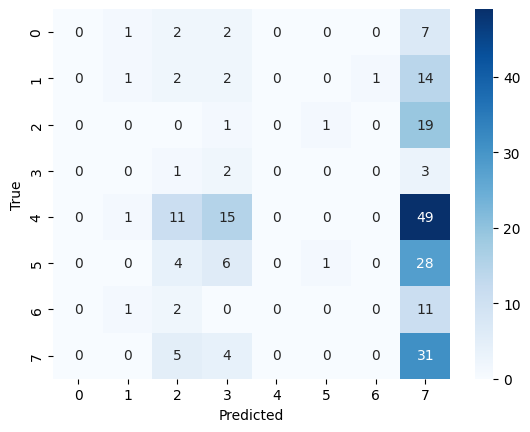

Colored loader:


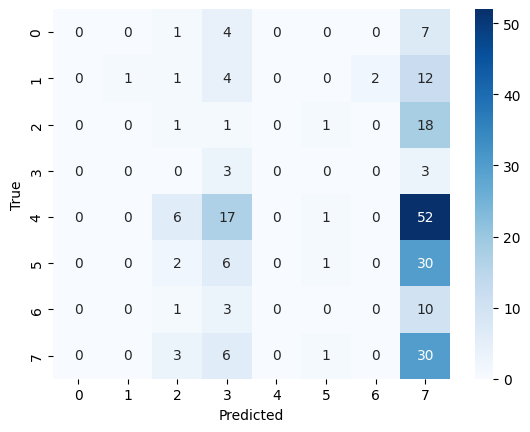

Training model: MyDenseNet

Training on Colored Data:


📊 Epoch 1: Train Loss = 2.0968, Val Loss = 2.1631, Val Acc = 9.65%
✅ Best model saved with Val Acc = 9.65%


📊 Epoch 2: Train Loss = 1.9996, Val Loss = 2.0525, Val Acc = 15.35%
✅ Best model saved with Val Acc = 15.35%


📊 Epoch 3: Train Loss = 1.9568, Val Loss = 2.1040, Val Acc = 13.16%


📊 Epoch 4: Train Loss = 1.8691, Val Loss = 2.1736, Val Acc = 13.16%


📊 Epoch 5: Train Loss = 1.8187, Val Loss = 2.0647, Val Acc = 14.47%


📊 Epoch 6: Train Loss = 1.7581, Val Loss = 2.1167, Val Acc = 17.11%
✅ Best model saved with Val Acc = 17.11%


📊 Epoch 7: Train Loss = 1.7552, Val Loss = 1.9882, Val Acc = 21.49%
✅ Best model saved with Val Acc = 21.49%


📊 Epoch 8: Train Loss = 1.6940, Val Loss = 2.3240, Val Acc = 7.89%


📊 Epoch 9: Train Loss = 1.6970, Val Loss = 2.2081, Val Acc = 10.09%


📊 Epoch 10: Train Loss = 1.6293, Val Loss = 2.1625, Val Acc = 20.18%
🎉 Training complete.

Training on Black & White Data:


📊 Epoch 1: Train Loss = 1.7687, Val Loss = 2.2214, Val Acc = 12.28%
✅ Best model saved with Val Acc = 12.28%


📊 Epoch 2: Train Loss = 1.7167, Val Loss = 2.1318, Val Acc = 20.61%
✅ Best model saved with Val Acc = 20.61%


📊 Epoch 3: Train Loss = 1.6509, Val Loss = 2.1095, Val Acc = 22.81%
✅ Best model saved with Val Acc = 22.81%


📊 Epoch 4: Train Loss = 1.6001, Val Loss = 2.1054, Val Acc = 20.18%


📊 Epoch 5: Train Loss = 1.5479, Val Loss = 2.0286, Val Acc = 28.95%
✅ Best model saved with Val Acc = 28.95%


📊 Epoch 6: Train Loss = 1.5005, Val Loss = 2.0750, Val Acc = 19.30%


📊 Epoch 7: Train Loss = 1.4750, Val Loss = 2.1376, Val Acc = 22.81%


📊 Epoch 8: Train Loss = 1.4383, Val Loss = 2.0876, Val Acc = 22.81%


📊 Epoch 9: Train Loss = 1.4590, Val Loss = 2.0887, Val Acc = 25.88%


📊 Epoch 10: Train Loss = 1.3809, Val Loss = 2.0928, Val Acc = 22.37%
🎉 Training complete.

Testing on Colored Data:


Testing: 100%|██████████| 87/87 [00:14<00:00,  6.04it/s]



Test Loss: 4.4364 | Test Accuracy: 13.68%

Testing on Black & White Data:


Testing: 100%|██████████| 87/87 [00:10<00:00,  8.45it/s]


Test Loss: 2.5317 | Test Accuracy: 9.18%
Black white loader:


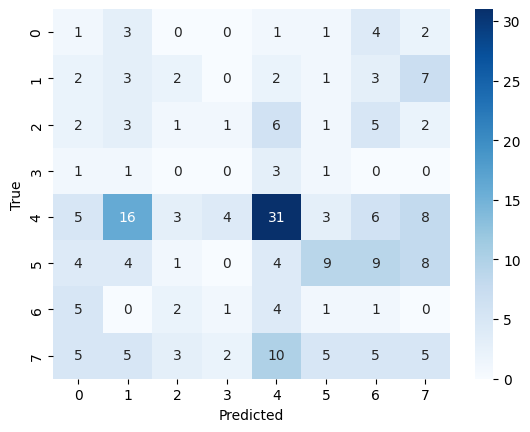

Colored loader:


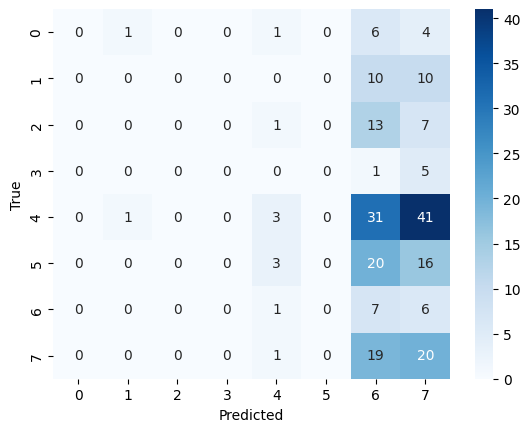

Training model: VGGFaceEmotionModel

Training on Colored Data:


📊 Epoch 1: Train Loss = 2.0957, Val Loss = 2.2788, Val Acc = 10.09%
✅ Best model saved with Val Acc = 10.09%


📊 Epoch 2: Train Loss = 1.9663, Val Loss = 2.1951, Val Acc = 11.40%
✅ Best model saved with Val Acc = 11.40%


📊 Epoch 3: Train Loss = 1.7678, Val Loss = 2.0315, Val Acc = 19.30%
✅ Best model saved with Val Acc = 19.30%


📊 Epoch 4: Train Loss = 1.7431, Val Loss = 2.1213, Val Acc = 14.91%


📊 Epoch 5: Train Loss = 1.6874, Val Loss = 2.0764, Val Acc = 15.79%


📊 Epoch 6: Train Loss = 1.6672, Val Loss = 2.0348, Val Acc = 20.61%
✅ Best model saved with Val Acc = 20.61%


📊 Epoch 7: Train Loss = 1.5173, Val Loss = 2.1490, Val Acc = 14.91%


📊 Epoch 8: Train Loss = 1.5022, Val Loss = 2.2318, Val Acc = 10.96%


📊 Epoch 9: Train Loss = 1.5113, Val Loss = 2.1369, Val Acc = 15.35%


📊 Epoch 10: Train Loss = 1.4842, Val Loss = 2.2216, Val Acc = 14.04%
🎉 Training complete.

Training on Black & White Data:


📊 Epoch 1: Train Loss = 1.7008, Val Loss = 2.3238, Val Acc = 10.53%
✅ Best model saved with Val Acc = 10.53%


📊 Epoch 2: Train Loss = 1.6410, Val Loss = 2.2063, Val Acc = 11.40%
✅ Best model saved with Val Acc = 11.40%


📊 Epoch 3: Train Loss = 1.5568, Val Loss = 2.1907, Val Acc = 16.67%
✅ Best model saved with Val Acc = 16.67%


📊 Epoch 4: Train Loss = 1.5317, Val Loss = 2.2284, Val Acc = 14.47%


📊 Epoch 5: Train Loss = 1.4902, Val Loss = 2.2908, Val Acc = 14.47%


📊 Epoch 6: Train Loss = 1.4397, Val Loss = 2.1626, Val Acc = 18.42%
✅ Best model saved with Val Acc = 18.42%


📊 Epoch 7: Train Loss = 1.4299, Val Loss = 2.1435, Val Acc = 22.81%
✅ Best model saved with Val Acc = 22.81%


📊 Epoch 8: Train Loss = 1.3300, Val Loss = 2.1185, Val Acc = 22.81%


📊 Epoch 9: Train Loss = 1.3327, Val Loss = 2.2522, Val Acc = 15.79%


📊 Epoch 10: Train Loss = 1.3166, Val Loss = 2.2591, Val Acc = 14.47%
🎉 Training complete.

Testing on Colored Data:


Testing: 100%|██████████| 87/87 [00:20<00:00,  4.18it/s]



Test Loss: 2.8692 | Test Accuracy: 9.98%

Testing on Black & White Data:


Testing: 100%|██████████| 87/87 [00:16<00:00,  5.28it/s]


Test Loss: 2.6534 | Test Accuracy: 10.20%
Black white loader:


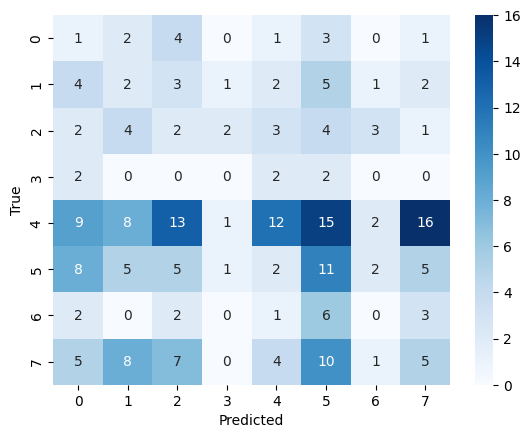

Colored loader:


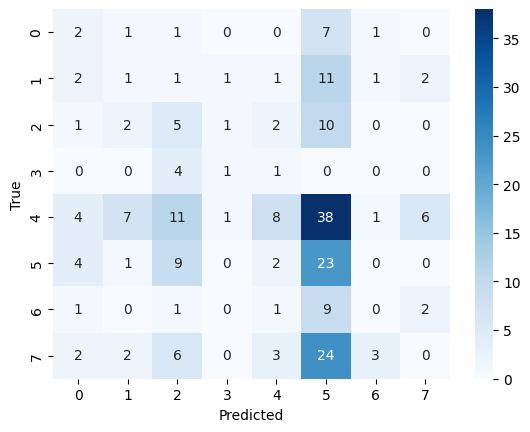

Training model: MyInceptionV3

Training on Colored Data:


📊 Epoch 1: Train Loss = 2.1226, Val Loss = 2.0928, Val Acc = 7.89%
✅ Best model saved with Val Acc = 7.89%


📊 Epoch 2: Train Loss = 2.0636, Val Loss = 2.0830, Val Acc = 8.33%
✅ Best model saved with Val Acc = 8.33%


📊 Epoch 3: Train Loss = 1.9823, Val Loss = 2.0235, Val Acc = 14.91%
✅ Best model saved with Val Acc = 14.91%


📊 Epoch 4: Train Loss = 1.9311, Val Loss = 1.9932, Val Acc = 21.93%
✅ Best model saved with Val Acc = 21.93%


📊 Epoch 5: Train Loss = 1.8980, Val Loss = 2.0486, Val Acc = 20.61%


📊 Epoch 6: Train Loss = 1.8720, Val Loss = 2.0047, Val Acc = 18.86%


📊 Epoch 7: Train Loss = 1.8298, Val Loss = 1.9261, Val Acc = 29.39%
✅ Best model saved with Val Acc = 29.39%


📊 Epoch 8: Train Loss = 1.8002, Val Loss = 2.1263, Val Acc = 16.23%


📊 Epoch 9: Train Loss = 1.7998, Val Loss = 2.1058, Val Acc = 20.18%


📊 Epoch 10: Train Loss = 1.7655, Val Loss = 1.9846, Val Acc = 23.68%
🎉 Training complete.

Training on Black & White Data:


📊 Epoch 1: Train Loss = 1.8383, Val Loss = 2.0039, Val Acc = 21.49%
✅ Best model saved with Val Acc = 21.49%


📊 Epoch 2: Train Loss = 1.7959, Val Loss = 1.9427, Val Acc = 23.25%
✅ Best model saved with Val Acc = 23.25%


📊 Epoch 3: Train Loss = 1.7124, Val Loss = 1.9903, Val Acc = 22.81%


📊 Epoch 4: Train Loss = 1.6810, Val Loss = 1.9526, Val Acc = 28.07%
✅ Best model saved with Val Acc = 28.07%


📊 Epoch 5: Train Loss = 1.6242, Val Loss = 2.0776, Val Acc = 18.86%


📊 Epoch 6: Train Loss = 1.6465, Val Loss = 2.0526, Val Acc = 20.61%


📊 Epoch 7: Train Loss = 1.5977, Val Loss = 2.0369, Val Acc = 15.79%


📊 Epoch 8: Train Loss = 1.6086, Val Loss = 1.9965, Val Acc = 21.05%


📊 Epoch 9: Train Loss = 1.5555, Val Loss = 1.9716, Val Acc = 22.81%


📊 Epoch 10: Train Loss = 1.5515, Val Loss = 2.0621, Val Acc = 17.11%
🎉 Training complete.

Testing on Colored Data:


Testing: 100%|██████████| 87/87 [00:17<00:00,  5.08it/s]



Test Loss: 2.3269 | Test Accuracy: 13.68%

Testing on Black & White Data:


Testing: 100%|██████████| 87/87 [00:12<00:00,  6.94it/s]


Test Loss: 2.3719 | Test Accuracy: 10.56%
Black white loader:


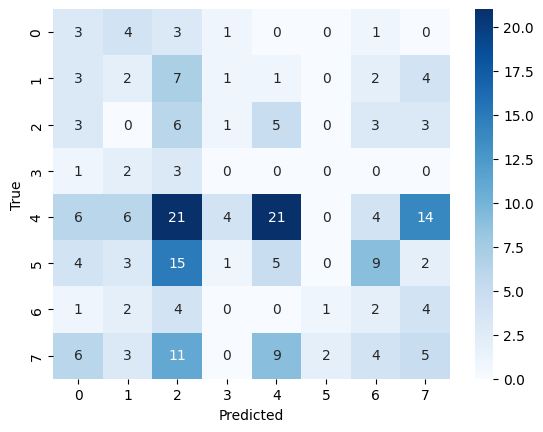

Colored loader:


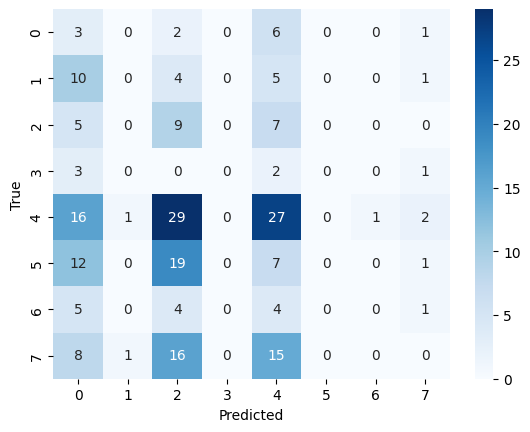

In [ ]:
train_all_models()

# Memory Optimized Code

### Initializing DataLoaders

In [ ]:
colored_train_loader = DataLoader(colored_train_dataset, batch_size=64, shuffle=True, num_workers=2, persistent_workers=False)
colored_valid_loader = DataLoader(colored_valid_dataset, batch_size=64, shuffle=False, num_workers=2)
colored_test_loader = DataLoader(colored_valid_dataset, batch_size=64, shuffle=False, num_workers=2)

bw_train_loader = DataLoader(bw_train_dataset, batch_size=64, shuffle=True, num_workers=2, persistent_workers=False)
bw_valid_loader = DataLoader(bw_valid_dataset, batch_size=64, shuffle=False, num_workers=2)
bw_test_loader = DataLoader(bw_valid_dataset, batch_size=64, shuffle=False, num_workers=2)

### Training Algorithm

In [ ]:
import random
from torch.utils.data import Subset


def train_model(model, train_loader, val_loader, epochs=10, lr=0.001, optimizer=None, loss_fn=None, bw=False, train_fraction=1.0):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = loss_fn if loss_fn is not None else torch.nn.CrossEntropyLoss()
    if optimizer is None:
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

    best_val_acc = 0.0
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        """
        # Get a random subset of the training data
        train_data_list = list(train_loader)
        random.shuffle(train_data_list)
        subset_size = int(len(train_data_list) * train_fraction)
        train_subset = train_data_list[:subset_size]
        """

        # Create a new Subset for the fraction
        num_samples = int(len(train_loader.dataset) * train_fraction)
        indices = random.sample(range(len(train_loader.dataset)), num_samples)
        subset_dataset = Subset(train_loader.dataset, indices)

        # Create a temporary DataLoader
        subset_loader = DataLoader(subset_dataset, batch_size=train_loader.batch_size, shuffle=True, num_workers=0)

        #loop = tqdm(train_subset, desc=f"Epoch {epoch+1}/{epochs} [Train]", leave=False)
        loop = tqdm(subset_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]", leave=False)


        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            if isinstance(outputs, tuple):
                outputs = outputs[0]

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            loop.set_postfix(loss=running_loss/len(subset_loader), acc=100. * correct / total)

        # Validation remains unchanged
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        val_acc = 100. * val_correct / val_total
        avg_val_loss = val_loss / len(val_loader)

        train_losses.append(running_loss / len(subset_loader))
        val_losses.append(avg_val_loss)

        print(f"📊 Epoch {epoch+1}: Train Loss = {running_loss/len(subset_loader):.4f}, "
              f"Val Loss = {avg_val_loss:.4f}, Val Acc = {val_acc:.2f}%")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            save_name = f"{model.__class__.__name__}_{'bw' if bw else 'color'}_best_model.pth"
            torch.save(model.state_dict(), save_name)
            print(f"✅ Best model saved with Val Acc = {val_acc:.2f}%")

    print("🎉 Training complete.")
    return train_losses, val_losses


For non pro-user: Running with T4 Gpu, High-RAM on

If you run out of gpu just run with cpu